In [8]:
import time
import numpy as np
import matplotlib.pyplot as plt
from os.path import exists
import json
import pickle

import torch
import torch.optim as optim
from torch.nn import CrossEntropyLoss, Conv2d, Sequential, BatchNorm2d
from torch.utils.data import DataLoader

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torchinfo import summary

from ActiveShiftLayer import ASL
from util import test_loss, train_NN, loadMNIST, inference_time, plot_loss, plot_acc, plot_shifts

In [9]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print(device)

cuda


## MNIST LeNet

In [10]:
batch_size = 100
input_shape = (batch_size, 1, 28, 28)
num_labels = 10

train_dataset, train_dataloader, test_dataset, test_dataloader, classes = loadMNIST(batch_size)

In [11]:
# mock train_function of Optimizer to load the optimizer
train_function = None

with open('models/LeNet/LeNet_optimizer.pkl', 'rb') as file:
    LeNet_optim = pickle.load(file)

parameters, acc= LeNet_optim.get_best_parameters()
print(parameters, acc) #maybe try more than one?

{'lr': 0.21875, 'momentum': 0.78125, 'p_randomTransform': 0.0625} 99.70666666666666


In [12]:
from Models import LeNet

LeNN = LeNet(input_shape, num_labels=num_labels, initial_lr=parameters["lr"], momentum=parameters["momentum"], weight_decay=0)

summary(LeNN, input_shape)

RuntimeError: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: []

In [6]:
PATH = "models/LeNet/LeNet.pth"

if exists(PATH):
    LeNN = torch.load(PATH)
    LeNN.eval()

In [6]:
criterion = CrossEntropyLoss()
epochs = 15

train_NN(LeNN, criterion, train_dataloader, test_dataloader, epochs=epochs, batches_to_test=100,
        patience=2, device=device, print_test=True, verbose=True, p_randomTransform=parameters["p_randomTransform"])

[1,   100] train_loss: 0.778
test_loss: 2.185, test_accuracy: 56.24
[1,   200] train_loss: 0.361
test_loss: 0.431, test_accuracy: 86.88
[1,   300] train_loss: 0.206
test_loss: 0.560, test_accuracy: 82.81
[1,   400] train_loss: 0.201
test_loss: 0.302, test_accuracy: 90.99
[1,   500] train_loss: 0.149
test_loss: 0.353, test_accuracy: 88.09
[1,   600] train_loss: 0.232
test_loss: 0.266, test_accuracy: 92.0
[2,   100] train_loss: 0.133
test_loss: 0.624, test_accuracy: 80.97
[2,   200] train_loss: 0.154
test_loss: 0.109, test_accuracy: 96.66
[2,   300] train_loss: 0.109
test_loss: 0.084, test_accuracy: 97.19
[2,   400] train_loss: 0.107
test_loss: 0.067, test_accuracy: 97.98
[2,   500] train_loss: 0.088
test_loss: 0.061, test_accuracy: 98.01
[2,   600] train_loss: 0.081
test_loss: 0.076, test_accuracy: 97.73
[3,   100] train_loss: 0.068
test_loss: 0.284, test_accuracy: 91.28
[3,   200] train_loss: 0.087
test_loss: 0.103, test_accuracy: 96.78
[3,   300] train_loss: 0.066
test_loss: 0.074, te

In [8]:
torch.save(LeNN, "./models/LeNet/LeNet.pth")

In [9]:
LeNN = torch.load("./models/LeNet/LeNet.pth")

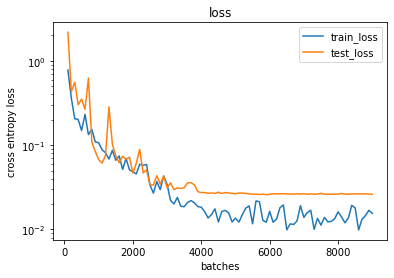

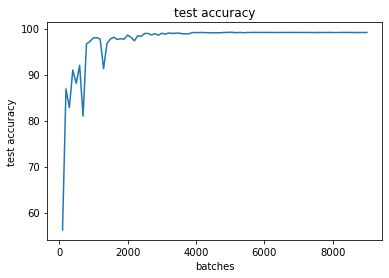

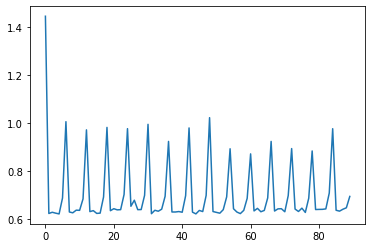

0.7028801493


In [7]:
plot_loss(LeNN)
plot_acc(LeNN)

plt.plot(LeNN.train_time)
plt.show()
print(np.mean(LeNN.train_time))

## MNIST LeASLNet

In [14]:
# mock train_function of Optimizer to load the optimizer
ASL_train_function = None

with open('models/LeNet/LeASLNet_optimizer.pkl', 'rb') as file:
    LeASLNet_optim = pickle.load(file)

parameters, acc= LeASLNet_optim.get_best_parameters()
print(parameters, acc)

{'lr': 0.4318430270465593, 'momentum': 0.5504980468750001, 'p_randomTransform': 0.00041015625000001554} 99.64666666666666


In [15]:
from Models import LeASLNet

LeASLNN = LeASLNet(input_shape, num_labels, initial_lr=parameters["lr"], momentum=parameters["momentum"], weight_decay=0, device=device, expansion_rate=1)

summary(LeASLNN, input_shape)

Layer (type:depth-idx)                   Output Shape              Param #
LeASLNet                                 [100, 10]                 --
├─Sequential: 1-1                        --                        --
│    └─Conv2d: 2-1                       [100, 6, 28, 28]          156
│    └─BatchNorm2d: 2-2                  [100, 6, 28, 28]          12
│    └─Tanh: 2-3                         [100, 6, 28, 28]          --
│    └─AvgPool2d: 2-4                    [100, 6, 14, 14]          --
│    └─CSC_block: 2-5                    [100, 16, 14, 14]         --
│    │    └─Sequential: 3-1              --                        108
│    │    └─Conv2d: 3-2                  [100, 16, 14, 14]         112
│    └─Tanh: 2-6                         [100, 16, 14, 14]         --
│    └─AvgPool2d: 2-7                    [100, 16, 7, 7]           --
│    └─Flatten: 2-8                      [100, 784]                --
│    └─Linear: 2-9                       [100, 120]                94,200
│    └─T

In [16]:
PATH = "models/LeNet/LeASLNet.pth"

if exists(PATH):
    LeASLNN = torch.load(PATH)
    LeASLNN.eval()

In [17]:
criterion = CrossEntropyLoss()
epochs = 15

train_NN(LeASLNN, criterion, train_dataloader, test_dataloader, epochs=epochs, batches_to_test=100,
        patience=2,device=device, print_test=True, verbose=True, p_randomTransform=parameters["p_randomTransform"])

[1,   100] train_loss: 0.009
test_loss: 0.034, test_accuracy: 98.98
[1,   200] train_loss: 0.012
test_loss: 0.034, test_accuracy: 98.98
[1,   300] train_loss: 0.013
test_loss: 0.034, test_accuracy: 98.98
[1,   400] train_loss: 0.012
test_loss: 0.034, test_accuracy: 98.98
Epoch 00004: reducing learning rate of group 0 to 1.6474e-06.
[1,   500] train_loss: 0.012
test_loss: 0.034, test_accuracy: 98.98
[1,   600] train_loss: 0.012
test_loss: 0.034, test_accuracy: 98.98
[2,   100] train_loss: 0.013
test_loss: 0.034, test_accuracy: 98.97
Epoch 00007: reducing learning rate of group 0 to 8.2368e-07.
[2,   200] train_loss: 0.011
test_loss: 0.034, test_accuracy: 98.98
[2,   300] train_loss: 0.012
test_loss: 0.034, test_accuracy: 98.98
[2,   400] train_loss: 0.011
test_loss: 0.034, test_accuracy: 98.98
Epoch 00010: reducing learning rate of group 0 to 4.1184e-07.
[2,   500] train_loss: 0.012
test_loss: 0.034, test_accuracy: 98.98
[2,   600] train_loss: 0.011
test_loss: 0.034, test_accuracy: 98.9

In [18]:
torch.save(LeASLNN, "./models/LeNet/LeASLNet.pth")

In [19]:
LeASLNN = torch.load("./models/LeNet/LeASLNet.pth")

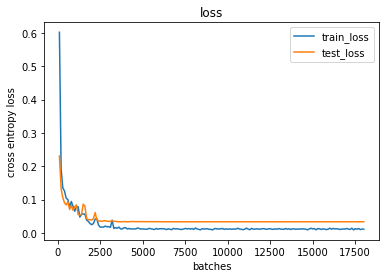

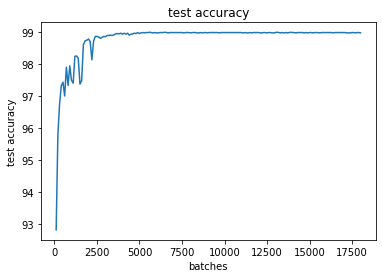

In [20]:
plot_loss(LeASLNN)
plot_acc(LeASLNN)

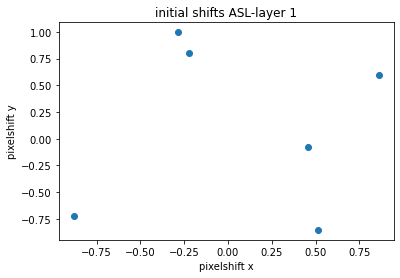

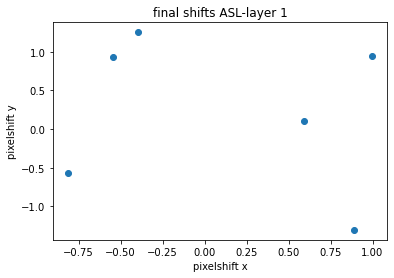

In [21]:
plot_shifts(LeASLNN)

## MNIST LeDepthNet

In [ ]:
# mock train_function of Optimizer to load the optimizer
train_function = None

with open('models/LeNet/LeDepthNet_optimizer.pkl', 'rb') as file:
    LeDepthNet_optim = pickle.load(file)

parameters, acc= LeDepthNet_optim.get_best_parameters()
print(parameters, acc)

In [9]:
from Models import LeDepthNet

LeDepthNN = LeDepthNet(input_shape, num_labels, initial_lr=parameters["lr"], momentum=parameters["momentum"], weight_decay=0, device=device)

summary(LeDepthNN, input_shape)

Layer (type:depth-idx)                   Output Shape              Param #
LeDepthNet                               [100, 10]                 --
├─Sequential: 1-1                        --                        --
│    └─Conv2d: 2-1                       [100, 6, 28, 28]          156
│    └─BatchNorm2d: 2-2                  [100, 6, 28, 28]          12
│    └─Tanh: 2-3                         [100, 6, 28, 28]          --
│    └─AvgPool2d: 2-4                    [100, 6, 14, 14]          --
│    └─Depth_wise_block: 2-5             [100, 16, 14, 14]         --
│    │    └─Sequential: 3-1              --                        226
│    └─Tanh: 2-6                         [100, 16, 14, 14]         --
│    └─AvgPool2d: 2-7                    [100, 16, 7, 7]           --
│    └─Flatten: 2-8                      [100, 784]                --
│    └─Linear: 2-9                       [100, 120]                94,200
│    └─Tanh: 2-10                        [100, 120]                --
│    └─Li

In [10]:
PATH = "models/LeNet/LeDepthNet.pth"

if exists(PATH):
    LeDepthNN = torch.load(PATH)
    LeDepthNN.eval()

In [15]:
criterion = CrossEntropyLoss()
epochs = 15

train_NN(LeDepthNN, criterion, train_dataloader, test_dataloader, epochs=epochs, batches_to_test=100,
        patience=2,device=device, print_test=True, verbose=True, p_randomTransform=parameters["p_randomTransform"])

[1,   100] train_loss: 0.036
test_loss: 0.047, test_accuracy: 98.46
[1,   200] train_loss: 0.034
test_loss: 0.048, test_accuracy: 98.42
[1,   300] train_loss: 0.032
test_loss: 0.049, test_accuracy: 98.44
[1,   400] train_loss: 0.040
test_loss: 0.050, test_accuracy: 98.42
[1,   500] train_loss: 0.039
test_loss: 0.050, test_accuracy: 98.38
Epoch 00006: reducing learning rate of group 0 to 1.2500e-03.
[1,   600] train_loss: 0.037
test_loss: 0.046, test_accuracy: 98.53
[2,   100] train_loss: 0.029
test_loss: 0.046, test_accuracy: 98.59
[2,   200] train_loss: 0.029
test_loss: 0.046, test_accuracy: 98.56
[2,   300] train_loss: 0.030
test_loss: 0.045, test_accuracy: 98.57
Epoch 00010: reducing learning rate of group 0 to 6.2500e-04.
[2,   400] train_loss: 0.031
test_loss: 0.045, test_accuracy: 98.57
[2,   500] train_loss: 0.028
test_loss: 0.045, test_accuracy: 98.58
[2,   600] train_loss: 0.027
test_loss: 0.044, test_accuracy: 98.62
[3,   100] train_loss: 0.029
test_loss: 0.045, test_accuracy

In [16]:
torch.save(LeDepthNN, "./models/LeNet/LeDepthNet.pth")

In [ ]:
LeDepthNN = torch.load("./models/LeNet/LeDepthNet.pth")

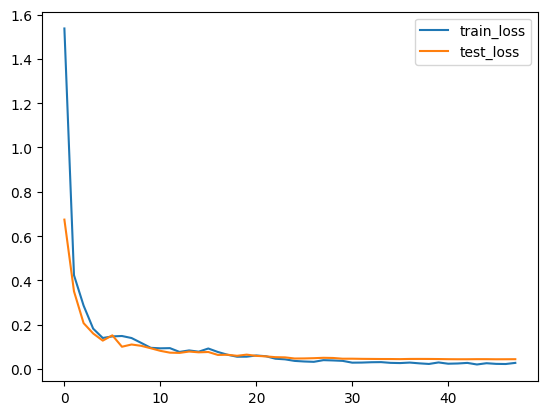

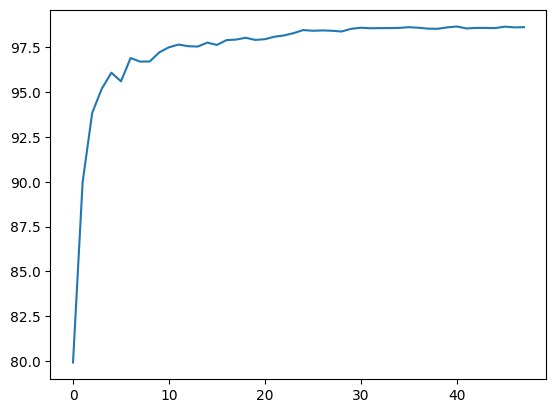

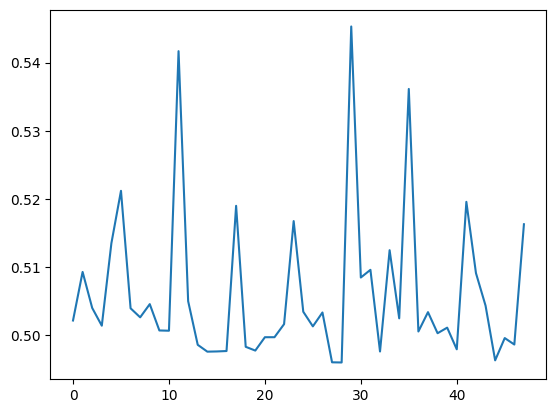

In [17]:
plot_loss(LeDepthNN)
plot_acc(LeDepthNN)

plt.hist(LeDepthNN.train_time)
plt.show()